# Building a Traffic Sign Recognition Classifier

## 1. Overview

I built a Convolutional Neural Network with TensorFlow and trained it to recognize traffic signs. The dataset used is the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb) dataset.

The final model achieves an accuracy of 97.9% on the official GTSRB test dataset.

The model includes my own implementation of batch normalization using a running average estimator of the population moments, along with a few tests and visualizations to see what batch normalization does.

All code, training results, and relevant explanations and comments are contained in this notebook, divided into sections.

---
## 2. Import modules

In [1]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

In [30]:
solution_dir = 'D:\\#ML\\traffic_sign_classifier\\'

---
## 3. Load Pickled Data

In [2]:
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

assert(len(train['features']) == len(train['labels']))
assert(len(test['features']) == len(test['labels']))

#A few prints to understand the data
print("'train' and 'test' are dictionaries with keys:", train.keys())
print("'features' in 'train' is a", type(train['features']), "of size", train['features'].shape)
print("'labels' in 'train' is a", type(train['labels']), "of size", train['labels'].shape)
print("'sizes' in 'train' is a", type(train['sizes']), "of size", train['sizes'].shape)
print("'coords' in 'train' is a", type(train['coords']), "of size", train['coords'].shape)

'train' and 'test' are dictionaries with keys: dict_keys(['sizes', 'labels', 'coords', 'features'])
'features' in 'train' is a <class 'numpy.ndarray'> of size (39209, 32, 32, 3)
'labels' in 'train' is a <class 'numpy.ndarray'> of size (39209,)
'sizes' in 'train' is a <class 'numpy.ndarray'> of size (39209, 2)
'coords' in 'train' is a <class 'numpy.ndarray'> of size (39209, 4)


---

## 4. Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4-D array containing raw pixel data of the traffic sign images (num examples, width, height, channels).
- `'labels'` is a 1-D array containing the label/class ID of the traffic sign. The file `signnames.csv` contains id -> name mappings for each ID.
- `'sizes'` is a list containing tuples (width, height) representing the original width and height of the image.
- `'coords'` is a list containing tuples (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. These coordinates assume the original images. The pickled data contains resized versions (32x32) of these images.

Here is a basic quantitative and visual summary of this data.

In [3]:
# Number of training, validation, and test examples, image resolution and color channels,
# and number of classification classes
n_train = len(train['features'])
n_test = len(test['features'])
image_shape = train['features'][0,:,:,:].shape

train_unique, train_counts = np.unique(train['labels'], return_counts='True')
test_unique, test_counts = np.unique(test['labels'], return_counts='True')
n_classes_train = len(train_unique)
n_classes_test = len(test_unique)

print("Number of training examples =", n_train)
print("Number of test examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes_train)
print("Number of classes in the test set =", n_classes_test)


Number of training examples = 39209
Number of test examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43
Number of classes in the test set = 43


Here is a basic visualization of the content of the GTSRB dataset. Execute the cell below multiple times to load new randomly selected images from the dataset. Change the grid_m and grid_n values and if needed the figsize to change the display.

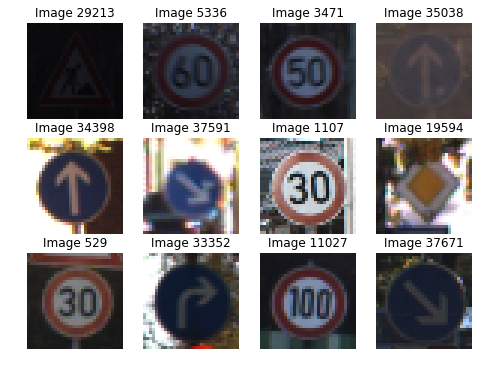

In [4]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(n_train, size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(train['features'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))


Below you can see a histogram of the number of tracks per classification category in the training dataset, illustrating a huge variance.

Some categories such as "0 - Speed limit (20km/h)" and "37 - Go straight or left" make up only around 0.6% and 0.5% of the training data and test data, respectively, while others such as "2 - Speed limit (50km/h)" make up around 6.1% and 5.9% - a difference of factor 10. With as few as 7 tracks of training examples for some classes (i.e. 7 unique physical traffic sign instances), this is very little data to train on for some classes.

We can assume that this frequency distribution roughly represents the real-world distribution of traffic signs, but nonetheless we don't want our classifier to be biased towards the more frequent traffic sign classes because it gets trained more on those. We need to monitor this using the validation dataset that I will create below (in which all classes will constitute the same fraction of the dataset, so a significant bias should become obvious in the form of a spread between the training accuracy and validation accuracy). It would, of course, be better if the training data was more equally distributed across the classes. Ideally, I would perform the data augmentation further below such that I generate more fake data for those classes with fewer images, and less for those classes with more, but for the sake of simplicity I'll just replicate the training data distribution when creating fake data.

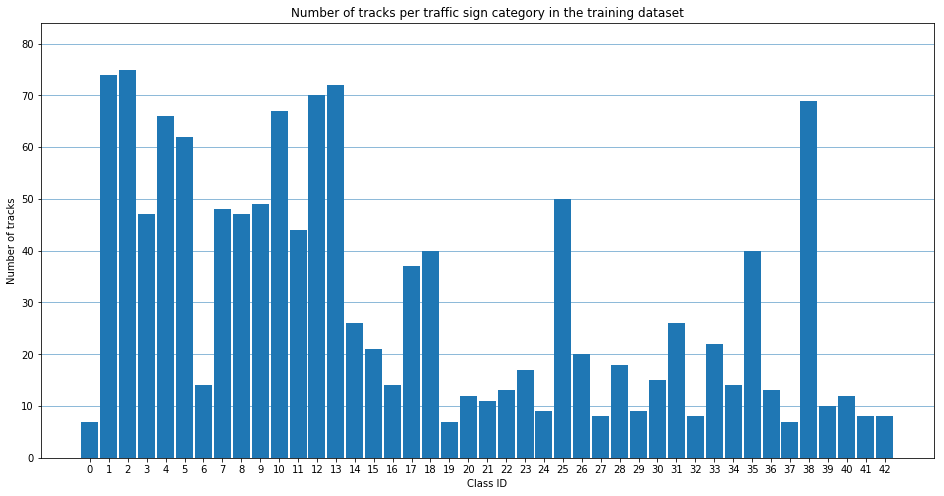

In [5]:
train_pcent = np.around(np.array([i/n_train for i in train_counts])*100, 1)
test_pcent = np.around(np.array([np.around(i/n_test, 3) for i in test_counts])*100, 1)

with open('./signnames.csv', newline='') as csvfile:
    csvread = csv.reader(csvfile, delimiter=',')
    signtable = {i[0]:i[1] for i in csvread}
signnames = [signtable[str(train_unique[i])] for i in train_unique]

n_tracks_train = (train_counts / 30).astype(int)
n_tracks_test = (test_counts / 30).astype(int)

class_table = np.array([train_unique, signnames, n_tracks_train, train_counts, train_pcent, n_tracks_test, test_counts, test_pcent]).T

np.set_printoptions(suppress=True, precision=1) # suppress scientific data format for printing because it's not very readable
#print(['Class Id', 'Desc.', '# Tracks Train', '# Train', '% Train', '# Tracks Test', '# Test', '% Test'])
#print(class_table)

f1, cell1 = plt.subplots(figsize=(16,8))
cell1.bar(range(len(n_tracks_train)), n_tracks_train, width=0.9)
cell1.set_ylabel("Number of tracks")
cell1.set_xlabel("Class ID")
cell1.set_xticks(np.arange(0,43,1))
cell1.set_title("Number of tracks per traffic sign category in the training dataset")
for ymaj in cell1.yaxis.get_majorticklocs():
    cell1.axhline(y=ymaj, linewidth=0.5)


---
## 5. Create a Validation Dataset

The GTSRB data only contains a training dataset and a test dataset. I'll create a small validation dataset for hyper parameter testing.

The fraffic sign examples in the GTSRB dataset were extracted from 1-second video sequences at 30 fps, hence for each physical traffic sign instance there are 30 samples of that same instance. In the terminology of the GTSRB dataset, the set of samples belonging to the same physical traffic sign instance is called a track. The samples within a track are obviously highly inter-correlated and as pointed out by [Sermanet et al.](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), in splitting off a validation dataset from the training dataset, one must make sure to exclusively split off complete tracks. If samples from the same track were spread across both the training and validation datasets, the validation dataset would no longer be a meaningful indicator of how the model performs on data that it has not been trained on.

The code below creates a validation dataset by randomly picking `n_pick` complete tracks from each of the 43 traffic sign classes and removing those tracks from the training dataset.

The number of tracks per class in the training dataset ranges from 7 to 75, and thus `n_pick` should be set to either 1 or 2 in order to retain a meaningful volume of training data for those classes with only 7 tracks. 

In [6]:
def val_split(features, labels, sizes, coords, n_pick=2, n_imgs_per_track=30):
    '''
    Split off a consistent subset from `features`, `labels`, `sizes`, and `coords`.
    
    The subset set will be constructed as follows: From each class in `labels`, randomly pick `n_pick` complete tracks.
    
    Args:
        features (array-like): A 4-D array containing raw pixel data of the images (num examples, width, height, channels).
        labels (array-like): A 1-D array containing the label/class ID of the image.
        sizes (array-like): A list containing tuples (width, height) representing the the original width and height of the image.
        coords (array-like): A list containing tuples (x1, y1, x2, y2) representing the coordinates of a bounding box
            around the traffic sign in the image.
        n_pick (int): The number of tracks to be picked from `features` for each class in `labels`. The maximum value is 6.
            Defaults to 2.
        n_imgs_per_track (int): The number of images per track in `features`. Defaults to 30.
        
    Returns:
        Eight numpy arrays containing features, labels, sizes, and coords of the same dimensions as their respective
        inputs for each the training and validation datasets.
    '''
    
    #Get the number of classes and the number of samples for each class
    train_unique, train_counts = np.unique(labels, return_counts='True')

    n_tracks = (train_counts / n_imgs_per_track).astype(int) #The number of tracks for any given class
    
    #Calculate a list of the cumulative number of images in all classes *before* a given class 'c'.
    #This is needed to calculate the start and end indices to select one track from each class to be picked
    #for the validation dataset.
    cum_imgs_per_class = np.zeros(len(train_unique), dtype='int')
    for k in range(1, len(train_unique)):
        cum_imgs_per_class[k:] += train_counts[k-1]

    #Collect the selection indices for the validation dataset
    val_indices = np.array([], dtype='int')
    for c in range(len(train_unique)): #For each class...
        val_tracks = random.sample(range(n_tracks[c]), n_pick) #...randomly select 'n_tracks_pick' tracks from that class...
        for k in val_tracks: #...and for each of the selected tracks...
            start = cum_imgs_per_class[c] + n_imgs_per_track * k #...calculate the start and end indices...
            end = start + n_imgs_per_track
            #print("class: ", c, "validation tracks picked: ", validation_tracks, "start: ", start, "end: ", end)
            val_indices = np.hstack((val_indices, np.r_[start:end])) #...and add them to the list and...
    
    #...now create a validation dataset with these indices and...
    val_features = np.take(features, val_indices, 0)
    val_labels = np.take(labels, val_indices, 0)
    val_sizes = np.take(sizes, val_indices, 0)
    val_coords = np.take(coords, val_indices, 0)

    #...create a new training dataset from the old training dataset by removing the validation data.
    train_features = np.take(features, sorted(set(range(len(features)))-set(val_indices)), 0)
    train_labels = np.take(labels, sorted(set(range(len(labels)))-set(val_indices)), 0)
    train_sizes = np.take(sizes, sorted(set(range(len(sizes)))-set(val_indices)), 0)
    train_coords = np.take(coords, sorted(set(range(len(coords)))-set(val_indices)), 0)
    
    return (train_features,
            train_labels,
            train_sizes,
            train_coords,
            val_features,
            val_labels,
            val_sizes,
            val_coords)

In [7]:
#Split off the validation dataset.
train_features, train_labels, train_sizes, train_coords, val_features, val_labels, val_sizes, val_coords = val_split(train['features'],
                                                                                                                     train['labels'],
                                                                                                                     train['sizes'],
                                                                                                                     train['coords'])

#Save it all to disk so that it is deterministic and faster for next time.
np.save('./val_features', val_features)
np.save('./val_labels', val_labels)
np.save('./val_sizes', val_sizes)
np.save('./val_coords', val_coords)

np.save('./train_features', train_features)
np.save('./train_labels', train_labels)
np.save('./train_sizes', train_sizes)
np.save('./train_coords', train_coords)

print("Training and validation datasets created and saved to disk.")
print()

n_train = len(train_features)
n_val = len(val_features)
n_test = len(test['features'])
image_shape = train_features[0,:,:,:].shape
n_classes = len(train_unique)
test_unique = np.unique(test['labels'], return_counts='False')
n_classes_test = len(test_unique)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes)
print("Number of classes in the test set =", n_classes_test)

Training and validation datasets created and saved to disk.

Number of training examples = 36629
Number of validation examples = 2580
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43
Number of classes in the test set = 2


In [8]:
# Load the datasets previously created.

train_features = np.load('./train_features.npy')
train_labels = np.load('./train_labels.npy')
val_features = np.load('./val_features.npy')
val_labels = np.load('./val_labels.npy')

testing_file = './test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---
## 6. Training Data Augmentation

36629 training examples is an alright amount, but we want more data for a more robust classifier. I will expand the training dataset by creating a few slightly transformed versions of every image. The art, of course, lies in applying only transformations that create realistic data - data that similarly appears (a) in the real world and (b) in the validation and test data.

I will use the following transformations, all of which create effects that naturally occur in the dataset:
- Viewpoint transformation
- Rotation
- Translation
- Scaling
- Brightness alteration
- [Histogram equalization](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)

You have to be careful, of course, not to overdo it with these transformations.

The cell below defines helper functions for each of the above transformations, and further below I'll show examples and ultimately generate the fake datasets.

**Note:**

Back when I wrote this project (it was one of my first machine learning projects) I naively generated a number of jittered versions of the training dataset, saved them all to disk and concatenated them all together with the original training dataset to form one much larger training dataset.

Older and wiser me realized that this is a waste of both hard drive space and, more importantly, memory. In this case you can get away with this naive approach since the images are so small, but with much larger images you might run out of memory if you try to load them all at once.

It will almost always be a better choice to write a generator that runs as a coroutine on a CPU and reads the training data from disk in mini-batches and performs data augmentation on them ad-hoc, while your model trains on a GPU. I did this in the behavioral cloning project which you can also find on my GitHub.

In [9]:
# Image processing functions to perform the following image manipulations:
# - Transform the perspective
# - Rotate
# - Translate
# - Scale
# - Change the brightness
# - Histogram-equalize

def perspective_transform(image, orientation='rand'):
    
    rows,cols,ch = image.shape
    
    k=3
    
    choices = [[5,5,5,5],
              [5,5,k,5+k]]
    choice = random.choice(choices)
    
    hdistl = choice[0] #Horizontal distortion from the left
    hdistr = choice[1] #Horizontal distortion from the right
    vdistt = choice[2] #Vertical distortion from the top
    vdistb = choice[3] #Vertical distortion from the bottom
    
    #Generate the point sets depending on the orientation passed.
    if orientation == 'rand':
        orientation = random.choice(['left', 'right'])
    
    if orientation == 'left':
        pts1 = np.float32([[0,k],[cols,k],[0,rows-k],[cols,rows-k]])
        pts2 = np.float32([[hdistl,vdistt],[cols-hdistr,0],[hdistl,rows-vdistb],[cols-hdistr,rows]])
    elif orientation == 'right':
        pts1 = np.float32([[0,k],[cols,k],[0,rows-k],[cols,rows-k]])
        pts2 = np.float32([[hdistl,0],[cols-hdistr,vdistt],[hdistl,rows],[cols-hdistr,rows-vdistb]])
    else: raise ValueError("No or unknown orientation given. Possible values are 'left' and 'right'.")
    
    #Calculate the transformation matrix, perform the transformation, and return it.
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, M, (rows, cols))

def rotate(image, min=5, max=15, orientation='rand'):
    
    rows,cols,ch = image.shape
    
    #Randomly select a rotation angle from the range passed.
    random_rot = np.random.randint(min, max+1)
    
    if orientation == 'rand':
        rotation_angle = random.choice([-random_rot, random_rot])
    elif orientation == 'left':
        rotation_angle = random_rot
    elif orientation == 'right':
        rotation_angle = -random_rot
    else:
        raise ValueError("Orientation is optional and can only be 'left' or 'right'.")
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def translate(image, min=2, max=2):
    
    rows,cols,ch = image.shape
    
    x = np.random.randint(min, max+1)
    y = np.random.randint(min, max+1)
    x_shift = random.choice([-x, x])
    y_shift = random.choice([-y, y])
    
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

def scale(image, min=0.9, max=1.1):
    
    rows,cols,ch = image.shape
    
    #Randomly select a rotation angle from the range passed.
    scale = np.random.uniform(min, max)
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 0, scale)
    return cv2.warpAffine(image, M, (cols, rows))

def brightness(image, min=0.5, max=2.0):
    
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    random_br = np.random.uniform(min,max)
    
    #To protect against overflow: Calculate a mask for all pixels
    #where adjustment of the brightness would exceed the maximum
    #brightness value and set the value to the maximum at those pixels.
    mask = hsv[:,:,2]*random_br > 255
    v_channel = np.where(mask, 255, hsv[:,:,2]*random_br)
    hsv[:,:,2] = v_channel
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

def histogram_eq(image):
    
    image1 = np.copy(image)
    
    image1[:,:,0] = cv2.equalizeHist(image1[:,:,0])
    image1[:,:,1] = cv2.equalizeHist(image1[:,:,1])
    image1[:,:,2] = cv2.equalizeHist(image1[:,:,2])
    
    return image1

Here is an example of each of the above manipulations:

Execute the cell below multiple times to get different random transformations.

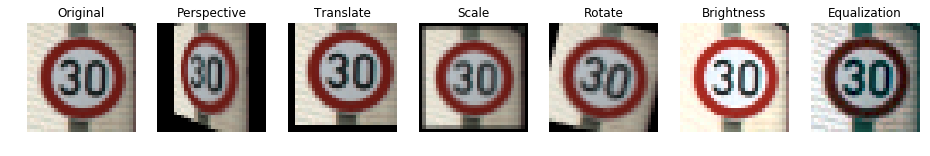

In [10]:
image = train_features[989]

transform_exmpl = [image,
                   perspective_transform(image),
                   translate(image),
                   scale(image),
                   rotate(image, min=10),
                   brightness(image),
                   histogram_eq(image)]

transform_descs = ['Original', 'Perspective', 'Translate', 'Scale', 'Rotate', 'Brightness', 'Equalization']

f2, cell2 = plt.subplots(1, 7, figsize=(16,6))
for i in range(7):
    cell2[i].imshow(transform_exmpl[i])
    cell2[i].axis('off')
    cell2[i].set_title(transform_descs[i])

The above transformations will be used in combination to produce jittered versions of the training dataset. Three such jittered versions will be created, according to the following transformations:

- Transform 1: Scale, then translate, then transform the perspective
- Transform 2: Adjust the brightness, then translate, then rotate
- Transform 3: Adjust the brightness, then scale, then translate

The resulting transforms applied to the example image above can be seen below.

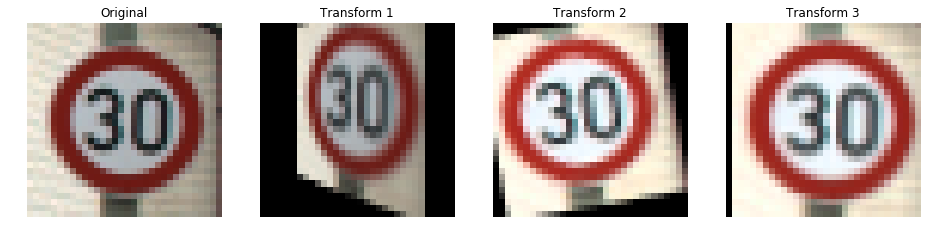

In [11]:
# Transform 1: Scale -> Translate -> Perspective Transform
transform1_exmpl = np.array([perspective_transform(translate(scale(image))) for image in train_features[989:990]])

# Transform 2: Brightness -> Translate -> Rotate
transform2_exmpl = np.array([rotate(translate(brightness(image))) for image in train_features[989:990]])

# Transform 3: Brightness -> Scale -> Translate
transform3_exmpl = np.array([translate(scale(brightness(image)), 0, 2) for image in train_features[989:990]])

transform_exmpl2 = [train_features[989], transform1_exmpl[0], transform2_exmpl[0], transform3_exmpl[0]]
transform_exmpl2_descs = ['Original', 'Transform 1', 'Transform 2', 'Transform 3']

f3, cell13 = plt.subplots(1, 4, figsize=(16,6))
for i in range(4):
    cell13[i].imshow(transform_exmpl2[i])
    cell13[i].axis('off')
    cell13[i].set_title(transform_exmpl2_descs[i])


In [12]:
# Produce the jittered datasets and save them to disk.
# Since the order of the images is left unchanged, we don't need to produce new label sets.

transform1_features = np.array([perspective_transform(translate(scale(image))) for image in train_features])
transform2_features = np.array([rotate(translate(brightness(image))) for image in train_features])
transform3_features = np.array([translate(scale(brightness(image)), 0, 2) for image in train_features])

np.save('./transform1_features', transform1_features)
np.save('./transform2_features', transform2_features)
np.save('./transform3_features', transform3_features)


An initial set of experiments training on the datasets generated above suggested that the first one of them, `transform1_features`, leads to slightly lower rather than higher validation accuracies. The experiments were not entirely conclusive, but the other two fake datasets achieved very good results, so I won't use the first one going forward.

Combining the original training dataset with the two generated datasets yields a total of 109,887 training examples. We could do better, but as we'll see in the experiments further below, a dataset of this size already gets us pretty far.

In [13]:
# Load the jittered datasets
#transform1_features = np.load('./transform1_features.npy')
transform2_features = np.load('./transform2_features.npy')
transform3_features = np.load('./transform3_features.npy')

# Concatenate the original training dataset and its jittered versions to one augmented training dataset.
augmented_training_features = np.concatenate((train_features,
                                              transform2_features,
                                              transform3_features))

augmented_training_labels = np.concatenate((train_labels,
                                            train_labels,
                                            train_labels))

# Check if everything went alright.
assert(len(augmented_training_features) == len(augmented_training_labels))
print("Number of training examples in the augmented training dataset: {}".format(len(augmented_training_features)))
print("Format of the augmented training features: {}".format(augmented_training_features.shape))
print("Format of the augmented training labels: {}".format(augmented_training_labels.shape))

Number of training examples in the augmented training dataset: 109887
Format of the augmented training features: (109887, 32, 32, 3)
Format of the augmented training labels: (109887,)


---
## 7. Data Preprocessing

The data is being converted from RGB to grayscale and the feature value range will be converted to [-1,1].

I ran initial tests with the baseline model used here to compare the performance on RGB against grayscale images with various configurations using different learning rates, regularization factors, initialization techniques, and using batch normalization or not. In almost all of the initial tests, the resulting models performed slightly worse on RGB images than on grayscale images (consistently with the findings of Sermanet et al.), so I chose to stick with grayscale input and focus on other optimization factors instead.

In [14]:
# Convert the training, validation, and test datasets from RGB to grayscale.
train_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_training_features]), 3)
val_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in val_features]), 3)
test_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in test['features']]), 3)

#This data is what we're actually going to train and test the model on.
X_train, y_train = train_features_gray / 127.5 - 1, augmented_training_labels
X_val, y_val = val_features_gray / 127.5 - 1, val_labels
X_test, y_test = test_features_gray / 127.5 - 1, test['labels']

In [15]:
X_train, y_train = shuffle(X_train, y_train)

---
## 8. Experimenting with Batch Normalization

The final model architecture used in this project implements batch normalization as first proposed by [Ioffe et al.](https://arxiv.org/abs/1502.03167). Since this is my first time implementing batch normalization, before I get to designing and training the actual model, I'll first do a few experiments here to better understand the effects of batch normalization.

I'll implement the following base model twice, once with and once without batch normalization, run both versions simultaneously, and look at the results:
- 1 input channel, i.e. grayscale input
- 2 convolutional layers, 64-108
- Convolutional filter size of 5x5 with a stride of 1 in each direction for both convolutional layers
- Max-pooling layers after each of the convolutional layers with a ksize and stride of 2 in each direction
- 2 fully connected layer with 100-43, the second going into a softmax classifier
- Batch normalization before the non-linearities of each layer (not before softmax)
- ReLU non-linearities for the first three layers
- Weights initialized with a standard deviation of 0.01 for both models

The hyper parameters that are different for the two models are: 
- Initial learning rate of 0.02 for BN, 0.001 for the regular model, decaying stepwise exponentially
- L2 regularization rate of 0.0005 for BN, 0.01 for the regular model

First, I'll write a batch normalization function that serves two purposes: It performs the mean and variance normalization of the inputs to the non-linearities of each layer during both training and inference time, and during training it also incrementally collects an estimator of the population means and variances to be used during inference.

In [16]:
# Define a batch normalization function that can distinguish between training and inference.

def batch_normalization(x, is_training, offset, scale, pop_mean, pop_var, layer_type, decay=0.99): 
    '''
    Perform batch normalization on the layer passed as 'x'.
    
    Calls one of two batch normalization functions depending on 'is_training'. If 'is_training' is
    true, calls 'train_normalize', which computes and applies the batch moments during training time
    and uses them to incrementally collect a moving average to compute an estimator of the population
    moments for inference. If 'is_training' is false, calls 'inference_normalize', which performs
    batch normalization during inference time using the population moments computed during training.
    '''
    return tf.cond(is_training,
                   lambda: train_normalize(x, offset, scale, pop_mean, pop_var, layer_type, decay),
                   lambda: inference_normalize(x, pop_mean, pop_var, offset, scale))

def train_normalize(x, offset, scale, pop_mean, pop_var, layer_type, decay):
    epsilon = 1e-4
    if layer_type=='conv':
        batch_mean, batch_var = tf.nn.moments(x, axes=[0, 1, 2])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)
    elif layer_type=='fc':
        batch_mean, batch_var = tf.nn.moments(x, axes=[0])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)
    else: raise ValueError("No or unknown layer type given. Supported layer types are convolutional ('conv') and fully connected ('fc').")

def inference_normalize(x, pop_mean, pop_var, offset, scale):
    epsilon = 1e-4
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, epsilon)

The function bellow builds a Tensorflow graph that will run training and inference on the same model with and without batch normalization simultaneously.

For every op and tensor in the graph on the path without batch normalization there is a corresponding op or tensor on the path with batch normalization, with a "_BN" appended to its name.

In [20]:
def build_graph_BNtest():
    
    #Set up a decaying learning rate.
    #It will decay exponentially at a rate of 'decay_rate', but only every 'decay_steps' steps.
    
    ilr = 0.001 #The initial learning rate for batch normalization
    global_step = tf.Variable(0, trainable=False) #This will be incremented by the 'minimize' function below.
    learning_rate = tf.train.exponential_decay(ilr, global_step, decay_steps=2000, decay_rate=0.9, staircase=True)
    
    ilr_BN = 0.02 #The initial learning rate for batch normalization
    global_step_BN = tf.Variable(0, trainable=False) #This will be incremented by the 'minimize' function below.
    learning_rate_BN = tf.train.exponential_decay(ilr_BN, global_step_BN, decay_steps=1000, decay_rate=0.9, staircase=True)
    
    #L2 regularization factor
    lmbda = 0.01
    lmbda_BN = 0.001
    
    sigma = 0.01
    
    n_input_channels = 1 #The number of color channels of the input data
    
    #The depth (i.e. number of conv feature maps / number of fully connected hidden neurons) of each layer.
    layer_depth = {
        'conv1': 64,
        'conv2': 108,
        'fc1': 100,
        'fc2': 43
    }
    
    #The convolutional filter size. Only one number is needed per layer since we're
    #using square filters (i.e. height = width) of identical size for all feature maps within a given layer.
    fsize = {
        '1': 5,
        '2': 5
    }
    
    #The convolutional stride and max pooling ksize are the same for all layers
    #and the pooling stride is always identical to the ksize.
    conv_stride = 1
    pool_k = 2
    
    is_training = tf.placeholder(tf.bool) #Flag for batch normalization to distinguish between training and inference.
    keep_prob = tf.placeholder(tf.float32) #Keep prob for dropout. Unused in this model.
    
    #Placeholders for the inputs.
    X = tf.placeholder(tf.float32, (None, 32, 32, n_input_channels))
    y = tf.placeholder(tf.int32, (None))
    y_one_hot = tf.one_hot(y, 43)
    
    #Generate predetermined random weights in order to initialize both networks identically.
    conv1_W_init = np.random.normal(scale=sigma, size=(fsize['1'], fsize['1'], n_input_channels, layer_depth['conv1']))
    conv2_W_init = np.random.normal(scale=sigma, size=(fsize['2'], fsize['2'], layer_depth['conv1'], layer_depth['conv2']))
    fc1_W_init = np.random.normal(scale=sigma, size=(5*5*layer_depth['conv2'],layer_depth['fc1']))
    fc2_W_init = np.random.normal(scale=sigma, size=(layer_depth['fc1'],layer_depth['fc2']))
    
    conv1_W_init = conv1_W_init.astype(np.float32)
    conv2_W_init = conv2_W_init.astype(np.float32)
    fc1_W_init = fc1_W_init.astype(np.float32)
    fc2_W_init = fc2_W_init.astype(np.float32)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(conv1_W_init)
    conv1_b = tf.Variable(tf.zeros(layer_depth['conv1']))
    conv1 = tf.nn.conv2d(X, conv1_W, [1,conv_stride,conv_stride,1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    conv1_W_BN = tf.Variable(conv1_W_init)
    conv1_beta = tf.Variable(tf.zeros(layer_depth['conv1'])) #Scale for batch normalization. Learnable parameter.
    conv1_gamma = tf.Variable(tf.ones(layer_depth['conv1'])) #Offset for batch normalization. Learnable parameter.
    conv1_pop_mean = tf.Variable(tf.zeros(layer_depth['conv1']), trainable=False) #An estimator of the population mean, estimated over the course of training. Not learnable.
    conv1_pop_var = tf.Variable(tf.ones(layer_depth['conv1']), trainable=False) #An estimator of the population variance, estimated over the course of training. Not learnable.
    conv1_BN = tf.nn.conv2d(X, conv1_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    conv1_BN = batch_normalization(conv1_BN, is_training, conv1_beta, conv1_gamma, conv1_pop_mean, conv1_pop_var, layer_type='conv')
    conv1_BN = tf.nn.relu(conv1_BN)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    conv1_BN = tf.nn.max_pool(conv1_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(conv2_W_init)
    conv2_b = tf.Variable(tf.zeros(layer_depth['conv2']))
    conv2 = tf.nn.conv2d(conv1, conv2_W, [1,conv_stride,conv_stride,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    
    #conv2_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['2'], fsize['2'], layer_depth['conv1'], layer_depth['conv2']), stddev = 1/(fsize['2']*np.sqrt(layer_depth['conv1']/2))))
    conv2_W_BN = tf.Variable(conv2_W_init)
    conv2_beta = tf.Variable(tf.zeros(layer_depth['conv2']))
    conv2_gamma = tf.Variable(tf.ones(layer_depth['conv2']))
    conv2_pop_mean = tf.Variable(tf.zeros(layer_depth['conv2']), trainable=False)
    conv2_pop_var = tf.Variable(tf.ones(layer_depth['conv2']), trainable=False)
    conv2_BN = tf.nn.conv2d(conv1_BN, conv2_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    batch_m, batch_v = tf.nn.moments(conv2_BN, axes=[0, 1, 2])
    conv2_BN = batch_normalization(conv2_BN, is_training, conv2_beta, conv2_gamma, conv2_pop_mean, conv2_pop_var, layer_type='conv')
    conv2_BN = tf.nn.relu(conv2_BN)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    conv2_BN = tf.nn.max_pool(conv2_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    fc0_BN = flatten(conv2_BN)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(fc1_W_init)
    fc1_b = tf.Variable(tf.zeros(layer_depth['fc1']))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    fc1_W_BN = tf.Variable(fc1_W_init)
    fc1_beta = tf.Variable(tf.zeros(layer_depth['fc1'])) 
    fc1_gamma = tf.Variable(tf.ones(layer_depth['fc1']))
    fc1_pop_mean = tf.Variable(tf.zeros(layer_depth['fc1']), trainable=False)
    fc1_pop_var = tf.Variable(tf.ones(layer_depth['fc1']), trainable=False)
    fc1_BN = tf.matmul(fc0_BN, fc1_W_BN)
    fc1_BN = batch_normalization(fc1_BN, is_training, fc1_beta, fc1_gamma, fc1_pop_mean, fc1_pop_var, layer_type='fc')
    fc1_BN = tf.nn.relu(fc1_BN)

    # Layer 4: Fully Connected. Input = 84. Output = 43.
    fc2_W = tf.Variable(fc2_W_init)
    fc2_b = tf.Variable(tf.zeros(layer_depth['fc2']))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2_W_BN = tf.Variable(fc2_W_init)
    fc2_b_BN = tf.Variable(tf.zeros(layer_depth['fc2']))
    logits_BN = tf.matmul(fc1_BN, fc2_W_BN) + fc2_b_BN
    
    #Softmax with cross entropy loss
    loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)) + lmbda*(tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W))
    loss_BN = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits_BN, labels=y_one_hot)) + lmbda_BN*(tf.nn.l2_loss(conv1_W_BN) + tf.nn.l2_loss(conv2_W_BN) + tf.nn.l2_loss(fc1_W_BN) + tf.nn.l2_loss(fc2_W_BN))
    
    #Adam minimizer
    training_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)
    training_step_BN = tf.train.AdamOptimizer(learning_rate=learning_rate_BN).minimize(loss_BN, global_step=global_step_BN)
    
    #Prediction accuracy op
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    correct_prediction_BN = tf.equal(tf.argmax(logits_BN, 1), tf.argmax(y_one_hot, 1))
    accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))
    
    return (X,
            y,
            is_training,
            keep_prob,
            training_step,
            training_step_BN,
            accuracy,
            accuracy_BN,
            fc1,
            fc1_BN,
            conv2_beta,
            conv2_gamma,
            conv2_pop_mean,
            conv2_pop_var,
            batch_m,
            batch_v,
            tf.train.Saver()
           )


In [18]:
#Small helper functions to evaluate the model in chunks of `batch_size`.

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_X, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(acc, feed_dict={X: batch_X, y: batch_y, keep_prob: 1.0, is_training: False})
        total_accuracy += (accuracy * len(batch_X))
    return total_accuracy / num_examples

def evaluate_BN(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_X, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(acc_BN, feed_dict={X: batch_X, y: batch_y, keep_prob: 1.0, is_training: False})
        total_accuracy += (accuracy * len(batch_X))
    return total_accuracy / num_examples

Interestingly, weight initialization seems to be paramount for training without batch normalization: If sigma is set to 0.1, or if the initialization method of He et al. is used, the network without batch normalization learns nothing - never reaching validation accuracies beyond chance even after many epochs of training, and even if the learning rate is extremely reduced to 0.0001 - which is a factor of 200 smaller than the learning rate of 0.02 that works great for the batch-normalized network. If, however, sigma is reduced by a factor of ten to 0.01, the network without batch normalization learns extremely well, achieving a validation accuracy of over 90% after only one epoch of training. In contrast to that, the network with batch normalization doesn't seem to care too much about initialization: It learns almost equally well in all three initialization cases (sigma = 0.01, sigma = 0.1, He et al. initialization), though slightly worse with sigma = 0.1. It seems particularly strange that the weight initialization method proposed by He et al. doesn't work for the non-batch-normalized network, since it was designed exactly for deep networks with ReLU non-linearities.

Let's train the model below.

In [27]:
epochs = 10
batch_size = 128

tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, training_step, training_step_BN, acc, acc_BN, fc1, fc1_BN, conv2_beta, conv2_gamma, conv2_pop_mean, conv2_pop_var, batch_m, batch_v, saver = build_graph_BNtest()

#Some lists where we'll save a summary of data of interest
fc1s, fc1s_BN, train_accs, train_accs_BN, val_accs, val_accs_BN = [], [], [], [], [], []
conv2_betas, conv2_gammas, conv2_pop_means, conv2_pop_vars, batch_ms, batch_vs = [], [], [], [], [], []

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    k = 0 #Counter for the number of training steps (i.e. number of minit batches processed)
    
    print("Training...")
    print()
    for i in range(epochs):
        print("EPOCH {} ...".format(i+1))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            #Create a mini batch
            end = offset + batch_size
            batch_X, batch_y = X_train[offset:end], y_train[offset:end]
            #Run a training step
            sess.run([training_step, training_step_BN], feed_dict={X: batch_X,
                                                                   y: batch_y,
                                                                   keep_prob: 0.5,
                                                                   is_training: True})
            k += 1 #Update the training step counter
            #Run the session with the validation dataset to obtain some variable values
            if k % 50 == 0:
                res = sess.run([fc1,
                                fc1_BN,
                                conv2_beta,
                                conv2_gamma,
                                conv2_pop_mean,
                                conv2_pop_var,
                                batch_m,
                                batch_v],
                               feed_dict={X: X_val,
                                          y: y_val,
                                          keep_prob: 1,
                                          is_training: False})
                fc1s.append(np.mean(res[0],axis=0)) #Record the mean value of fc1 over the entire validation set
                fc1s_BN.append(np.mean(res[1],axis=0)) #Record the mean value of fc1_BN over the entire validation set
                conv2_betas.append(res[2])
                conv2_gammas.append(res[3])
                conv2_pop_means.append(res[4])
                conv2_pop_vars.append(res[5])
                batch_ms.append(res[6])
                batch_vs.append(res[7])
        #Evaluate the accuracy of the last epoch
        training_accuracy = evaluate(X_train, y_train)
        training_accuracy_BN = evaluate_BN(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        validation_accuracy_BN = evaluate_BN(X_val, y_val)
        train_accs.append(training_accuracy)
        train_accs_BN.append(training_accuracy_BN)
        val_accs.append(validation_accuracy)
        val_accs_BN.append(validation_accuracy_BN)
        
        print("Number of training steps: {}".format(k))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Training Accuracy with BN = {:.3f}".format(training_accuracy_BN))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Accuracy with BN = {:.3f}".format(validation_accuracy_BN))
        print("Time elapsed: %s seconds" % round(time.time() - start_time, 0))
        print()
    
    model_name = solution_dir + 'p0_BN_test_model_01'
    saved_model = saver.save(sess, model_name)
    print("Model saved as {}".format(model_name))
    
    fc1s, fc1s_BN, train_accs, train_accs_BN, val_accs, val_accs_BN = np.array(fc1s), np.array(fc1s_BN), np.array(train_accs), np.array(train_accs_BN), np.array(val_accs), np.array(val_accs_BN)
    conv2_betas, conv2_gammas, conv2_pop_means, conv2_pop_vars = np.array(conv2_betas), np.array(conv2_gammas), np.array(conv2_pop_means), np.array(conv2_pop_vars)
    batch_ms, batch_vs = np.array(batch_ms), np.array(batch_vs)
    
    np.save('{}_fc1s'.format(model_name), fc1s)
    np.save('{}_fc1s_BN'.format(model_name), fc1s_BN)
    np.save('{}_train_accs'.format(model_name), train_accs)
    np.save('{}_train_accs_BN'.format(model_name), train_accs_BN)
    np.save('{}_val_accs'.format(model_name), val_accs)
    np.save('{}_val_accs_BN'.format(model_name), val_accs_BN)
    np.save('{}_conv2_betas'.format(model_name), conv2_betas)
    np.save('{}_conv2_gammas'.format(model_name), conv2_gammas)
    np.save('{}_conv2_pop_means'.format(model_name), conv2_pop_means)
    np.save('{}_conv2_pop_vars'.format(model_name), conv2_pop_vars)
    np.save('{}_conv2_batch_ms'.format(model_name), batch_ms)
    np.save('{}_conv2_batch_vs'.format(model_name), batch_vs)


Training...

EPOCH 1 ...
Number of training steps: 859
Training Accuracy = 0.870
Training Accuracy with BN = 0.934
Validation Accuracy = 0.848
Validation Accuracy with BN = 0.906
Time elapsed: 31.0 seconds

EPOCH 2 ...
Number of training steps: 1718
Training Accuracy = 0.942
Training Accuracy with BN = 0.932
Validation Accuracy = 0.896
Validation Accuracy with BN = 0.909
Time elapsed: 62.0 seconds

EPOCH 3 ...
Number of training steps: 2577
Training Accuracy = 0.966
Training Accuracy with BN = 0.934
Validation Accuracy = 0.913
Validation Accuracy with BN = 0.897
Time elapsed: 92.0 seconds

EPOCH 4 ...
Number of training steps: 3436
Training Accuracy = 0.975
Training Accuracy with BN = 0.954
Validation Accuracy = 0.921
Validation Accuracy with BN = 0.929
Time elapsed: 123.0 seconds

EPOCH 5 ...
Number of training steps: 4295
Training Accuracy = 0.981
Training Accuracy with BN = 0.960
Validation Accuracy = 0.910
Validation Accuracy with BN = 0.906
Time elapsed: 153.0 seconds

EPOCH 6 ...

OSError: [Errno 22] Invalid argument: 'D:\\#ML\\traffic_sign_classifier\\D:\\#ML\\traffic_sign_classifier\\p0_BN_test_model_01_fc1s.npy'

Confusingly, the model without batch normalization doesn't seem to be learning slower than the model with batch normalization, despite a much lower initial learning rate. If you can spot a bug in my implementation, please let me know. After 10 epochs (granted, that isn't that much) the results are inconclusive about which model performed better. In initial tests I ran, I at first observed that batch normalization performed a lot better, but in hindsight that might also have been due to suboptimal hyper parameter choices for the regular model, since right now I can't seem to be able to reproduce a scenario where a model without batch normalization behaves significantly worse. Any feedback that helps me understand this is very welcome!

Let's compare at the accuracies of the two models, and let's look at layer activations side by side and variances further below.

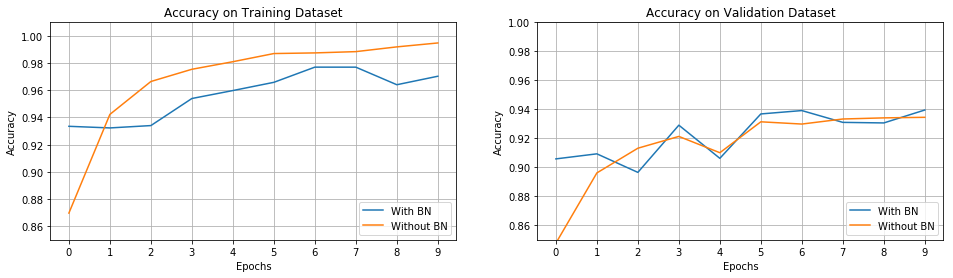

In [31]:
#Plot the training and validation accuracy

train_accs = np.load(solution_dir + 'p0_BN_test_model_01_train_accs.npy')
train_accs_BN = np.load(solution_dir + 'p0_BN_test_model_01_train_accs_BN.npy')
val_accs = np.load(solution_dir + 'p0_BN_test_model_01_val_accs.npy')
val_accs_BN = np.load(solution_dir + 'p0_BN_test_model_01_val_accs_BN.npy')

fig0, axes0 = plt.subplots(1, 2, figsize=(16,4))

axes0[0].plot(range(0,len(train_accs_BN)),train_accs_BN, label='With BN')
axes0[0].plot(range(0,len(train_accs)),train_accs, label='Without BN')
axes0[0].set_xlabel('Epochs')
axes0[0].set_ylabel('Accuracy')
axes0[0].set_xticks(range(0,len(train_accs),1))
axes0[0].set_ylim([0.85,1.01])
axes0[0].set_title('Accuracy on Training Dataset')
axes0[0].legend(loc=4)
axes0[0].grid(True)
axes0[1].plot(range(0,len(val_accs_BN)),val_accs_BN, label='With BN')
axes0[1].plot(range(0,len(val_accs)),val_accs, label='Without BN')
axes0[1].set_xlabel('Epochs')
axes0[1].set_ylabel('Accuracy')
axes0[1].set_xticks(range(0,len(val_accs),1))
axes0[1].set_ylim([0.85,1])
axes0[1].set_title('Accuracy on Validation Dataset')
axes0[1].legend(loc=4)
axes0[1].grid(True)

plt.show()

Below I'm looking at some variables from the second convolutional layer. The developments of the variables beta, gamma, population mean, population variance, batch mean, and batch variance all look as expected, converging as training progresses.

You can change 'j' to look at a different feature map to display.

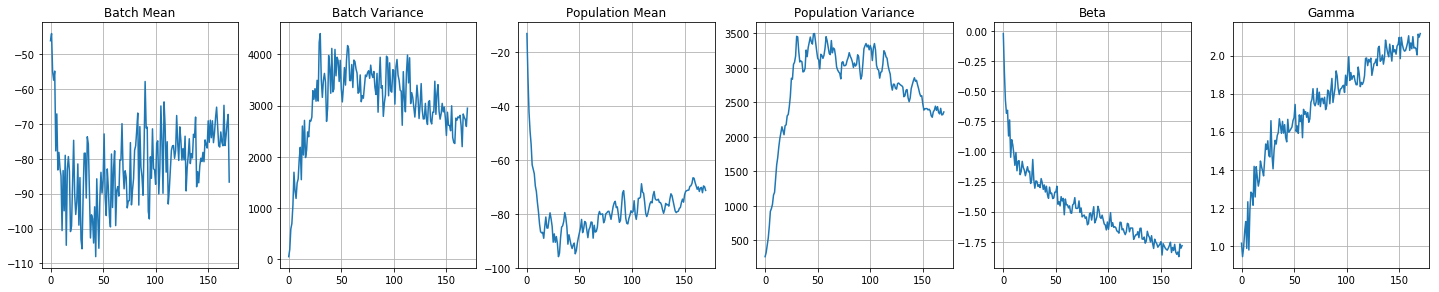

In [33]:
conv2_betas = np.load(solution_dir + 'p0_BN_test_model_01_conv2_betas.npy')
conv2_gammas = np.load(solution_dir + 'p0_BN_test_model_01_conv2_gammas.npy')
conv2_pop_means = np.load(solution_dir + 'p0_BN_test_model_01_conv2_pop_means.npy')
conv2_pop_vars = np.load(solution_dir + 'p0_BN_test_model_01_conv2_pop_vars.npy')
conv2_batch_ms = np.load(solution_dir + 'p0_BN_test_model_01_conv2_batch_ms.npy')
conv2_batch_vs = np.load(solution_dir + 'p0_BN_test_model_01_conv2_batch_vs.npy')

fig1, axes1 = plt.subplots(1, 6, figsize=(20,4))
fig1.tight_layout()

#Select the feature map to display
j = 3

axes1[0].set_title("Batch Mean")
axes1[1].set_title("Batch Variance")
axes1[2].set_title("Population Mean")
axes1[3].set_title("Population Variance")
axes1[4].set_title("Beta")
axes1[5].set_title("Gamma")
axes1[0].plot(conv2_batch_ms[:,j])
axes1[1].plot(conv2_batch_vs[:,j])
axes1[2].plot(conv2_pop_means[:,j])
axes1[3].plot(conv2_pop_vars[:,j])
axes1[4].plot(conv2_betas[:,j])
axes1[5].plot(conv2_gammas[:,j])
for ax in axes1:
    ax.grid(True)

Below I'm looking at the activations of five units from the first fully connected layer after the ReLU non-linearity.

It would have been better to let the training run much longer, but the general picture seems to indicate that batch normalization does what it should: The units in the model without batch normalization show a much greater variance (note the scale on the y-axis) and seem to change their general trajectory during training, while their respective counterparts in the batch-normalized model converge more directly in one direction that doesn't change much over the course of the training.

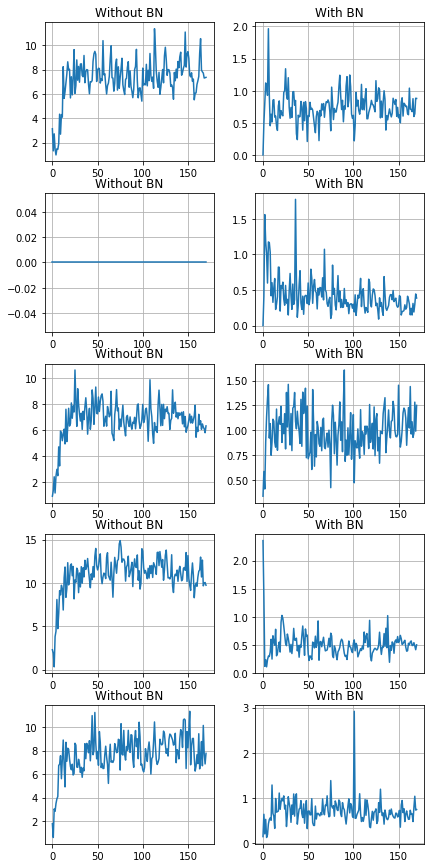

In [35]:
fc1s = np.load(solution_dir +'p0_BN_test_model_01_fc1s.npy')
fc1s_BN = np.load(solution_dir +'p0_BN_test_model_01_fc1s_BN.npy')

fig2, axes2 = plt.subplots(5, 2, figsize=(6,12))
fig2.tight_layout()

#Select the first of five consecutive neurons to display.
j1 = 40

for i, ax in enumerate(axes2):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(fc1s[:,i+j1])
    ax[1].plot(fc1s_BN[:,i+j1])
    ax[0].grid(True)
    ax[1].grid(True)

In conclusion, even though my probably insufficient experiments here don't show batch normalization to be far superior (contrary to what I would have expected - again, feedback helping me understand this is very much appreciated), I'll still implement it in the general model architecture that will serve as a basis for further testing below.

---
## 9. Architecture and Configuration Testing

Now let's get to the actual model testing and training.

Below I'll set up a test pipeline to test various network configurations.

Thanks to the paper of Sermanet et al. I already have a starting point: I know that four layers (2 convolutional and 2 fully connected) are sufficient to achieve accuracies around 99%. Hence, my architecture experimentation will be limited to trying out different depths for the two convolutional layers.

The basic network that will be tested has two convolutional layers followed by two fully connected layers including the classifier, which uses softmax. Batch normalization and dropout (keep_rate=0.5) are performed on each hidden layer, and L2 regularization is added.

The parameters that will be varied are **learning rate**, **L2 regularization rate**, and **number of feature maps in the convolutional layers** of the network. These tests will serve as a basis for further tweaking and will of course only provide a rough orientation: I only trained for 10 epochs due to limited computational resources, and I'm not testing nearly as many hyper parameter configurations and architectures as I'd like to. Nonetheless these tests provide a helpful basis.

You'll find further comments in the following paragraphs.

**Note:**

Once again, back when I wrote this project, I followed the naive approach of doing grid search over fixed, deterministic sets of mostly equidistant hyper parameter values.

It is smarter to do grid search with random values for each hyperparameter, as it let's you try a lot more different values for each hyper parameter in the same time.

In [45]:
def build_graph_p1(ilr, lmbda, layer_depth):
    
    #Set up a decaying learning rate.
    #It will decay exponentially at a rate of 'decay_rate', but only every 'decay_steps' steps.
    ilr_BN = ilr #The initial learning rate for batch normalization
    global_step_BN = tf.Variable(0, trainable=False) #This will be incremented by the 'minimize' function below.
    learning_rate_BN = tf.train.exponential_decay(ilr_BN, global_step_BN, decay_steps=800, decay_rate=0.85, staircase=True)
    
    #L2 regularization factor
    lmbda_BN = lmbda
    
    sigma = 0.01
    
    n_input_channels = 1 #The number of color channels of the input data
    
    #The depth (i.e. number of conv feature maps / number of fully connected hidden neurons) of each layer.
    layer_depth = layer_depth
    
    #The convolutional filter size. Only one number is needed per layer since we're
    #using square filters (i.e. height = width) of identical size for all feature maps within a given layer.
    fsize = {
        '1': 5,
        '2': 5
    }
    
    #The convolutional stride and max pooling ksize are the same for all layers
    #and the pooling stride is always identical to the ksize.
    conv_stride = 1
    pool_k = 2
    
    #Placeholders for the dropout keep probability and the is_training flag.
    is_training = tf.placeholder(tf.bool)
    keep_prob = tf.placeholder(tf.float32)
    
    #Placeholders for the inputs.
    X = tf.placeholder(tf.float32, (None, 32, 32, n_input_channels))
    y = tf.placeholder(tf.int32, (None))
    y_one_hot = tf.one_hot(y, 43)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['1'], fsize['1'], n_input_channels, layer_depth['conv1']), stddev = sigma))
    conv1_beta = tf.Variable(tf.zeros(layer_depth['conv1'])) #Scale for batch normalization. Learnable parameter.
    conv1_gamma = tf.Variable(tf.ones(layer_depth['conv1'])) #Offset for batch normalization. Learnable parameter.
    conv1_pop_mean = tf.Variable(tf.zeros(layer_depth['conv1']), trainable=False) #An estimator of the population mean, estimated over the course of training. Not learnable.
    conv1_pop_var = tf.Variable(tf.ones(layer_depth['conv1']), trainable=False) #An estimator of the population variance, estimated over the course of training. Not learnable.
    conv1_BN = tf.nn.conv2d(X, conv1_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    conv1_BN = batch_normalization(conv1_BN, is_training, conv1_beta, conv1_gamma, conv1_pop_mean, conv1_pop_var, layer_type='conv')
    conv1_BN = tf.nn.relu(conv1_BN)
    conv1_BN = tf.nn.dropout(conv1_BN, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_BN = tf.nn.max_pool(conv1_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['2'], fsize['2'], layer_depth['conv1'], layer_depth['conv2']), stddev = sigma))
    conv2_beta = tf.Variable(tf.zeros(layer_depth['conv2']))
    conv2_gamma = tf.Variable(tf.ones(layer_depth['conv2']))
    conv2_pop_mean = tf.Variable(tf.zeros(layer_depth['conv2']), trainable=False)
    conv2_pop_var = tf.Variable(tf.ones(layer_depth['conv2']), trainable=False)
    conv2_BN = tf.nn.conv2d(conv1_BN, conv2_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    batch_m, batch_v = tf.nn.moments(conv2_BN, axes=[0, 1, 2])
    conv2_BN = batch_normalization(conv2_BN, is_training, conv2_beta, conv2_gamma, conv2_pop_mean, conv2_pop_var, layer_type='conv')
    conv2_BN = tf.nn.relu(conv2_BN)
    conv2_BN = tf.nn.dropout(conv2_BN, keep_prob)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_BN = tf.nn.max_pool(conv2_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0_BN = flatten(conv2_BN)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W_BN = tf.Variable(tf.truncated_normal(shape=(5*5*layer_depth['conv2'],layer_depth['fc1']), stddev = sigma))
    fc1_beta = tf.Variable(tf.zeros(layer_depth['fc1'])) 
    fc1_gamma = tf.Variable(tf.ones(layer_depth['fc1']))
    fc1_pop_mean = tf.Variable(tf.zeros(layer_depth['fc1']), trainable=False)
    fc1_pop_var = tf.Variable(tf.ones(layer_depth['fc1']), trainable=False)
    fc1_BN = tf.matmul(fc0_BN, fc1_W_BN)
    fc1_BN = batch_normalization(fc1_BN, is_training, fc1_beta, fc1_gamma, fc1_pop_mean, fc1_pop_var, layer_type='fc')
    fc1_BN = tf.nn.relu(fc1_BN)
    fc1_BN = tf.nn.dropout(fc1_BN, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc2_W_BN = tf.Variable(tf.truncated_normal(shape=(layer_depth['fc1'],layer_depth['fc2']), stddev = sigma))
    fc2_b_BN = tf.Variable(tf.zeros(layer_depth['fc2']))
    logits_BN = tf.matmul(fc1_BN, fc2_W_BN) + fc2_b_BN
    softmax_BN = tf.nn.softmax(logits_BN) #This is not the input to the loss op, but we need it for other reasons.
    
    #Softmax with cross entropy loss
    loss_BN = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits_BN, labels=y_one_hot)) + lmbda_BN*(tf.nn.l2_loss(conv1_W_BN) + tf.nn.l2_loss(conv2_W_BN) + tf.nn.l2_loss(fc1_W_BN) + tf.nn.l2_loss(fc2_W_BN))
    
    #Adam minimizer
    training_step_BN = tf.train.AdamOptimizer(learning_rate=learning_rate_BN).minimize(loss_BN, global_step=global_step_BN)
    
    #Prediction accuracy op
    correct_prediction_BN = tf.equal(tf.argmax(logits_BN, 1), tf.argmax(y_one_hot, 1))
    accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))
    
    return (X,
            y,
            is_training,
            keep_prob,
            softmax_BN,
            training_step_BN,
            accuracy_BN,
            correct_prediction_BN,
            tf.train.Saver()
           )


36 configurations will be tested in total, namely all combinations of the following:

- 6 different learning rates, which are roughly by a factor of 3 apart from each other
- 3 different L2 regularization rates
- 2 alternatives for the number of feature maps in the two convolutional layers: 64-108 and 108-200

In [46]:
learn_rate_list = [0.06, 0.02, 0.006, 0.002, 0.0006, 0.0002]
l2reg_rate_list = [0.005, 0.001, 0.0005]

ld1 = {'conv1': 64, 'conv2': 108, 'fc1': 100, 'fc2': 43}
ld2 = {'conv1': 108, 'conv2': 200, 'fc1': 100, 'fc2': 43}
layer_depth_list = [ld1, ld2]

In [47]:
epochs = 10
batch_size = 128

validation_accuracies = []
configuration_titles = []

start_time = time.time()

for ld in layer_depth_list:
    for lmbda in l2reg_rate_list:
        for ilr in learn_rate_list:
            
            print("Training new model. Learning rate={}, regularization rate={}, conv1={}".format(ilr, lmbda, ld['conv1']))
            print()
            tf.reset_default_graph()
            
            val_accs = []
            
            #Build the graph
            X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p1(ilr, lmbda, ld)
            
            #Run the training session
            with tf.Session() as sess:
                
                sess.run(tf.global_variables_initializer())
                num_examples = len(X_train)
                k = 0 #Counter for the number of training steps (i.e. number of minit batches processed)

                print("Training...")
                print()
                for i in range(epochs):
                    print("EPOCH {} ...".format(i+1))
                    X_train, y_train = shuffle(X_train, y_train)
                    for offset in range(0, num_examples, batch_size):
                        #Create a mini batch
                        end = offset + batch_size
                        batch_X, batch_y = X_train[offset:end], y_train[offset:end]
                        #Run a training step
                        sess.run(training_step, feed_dict={X: batch_X,
                                                           y: batch_y,
                                                           keep_prob: 0.5,
                                                           is_training: True})
                        k += 1
                    #Evaluate the accuracy of the last epoch
                    training_accuracy = evaluate(X_train, y_train)
                    validation_accuracy = evaluate(X_val, y_val)
                    val_accs.append(validation_accuracy)

                    print("Training Accuracy = {:.3f}".format(training_accuracy))
                    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                    print("Number of training steps: {}".format(k))
                    print("Time elapsed: %s seconds" % round(time.time() - start_time, 0))
                    print()
                
                validation_accuracies.append(val_accs)
                val_accs_array = np.array(validation_accuracies)
                np.save(solution_dir +'validation_accuracies_all-1', val_accs_array)
                
                model_name = solution_dir +"conv1{}-lmbda{}-ilr{}".format(ld['conv1'], lmbda, ilr)
                configuration_titles.append(model_name)
                val_accs_titles = np.array(configuration_titles)
                np.save(solution_dir +'validation_accuracies_titles-1', val_accs_titles)
                
                saved_model = saver.save(sess, model_name)
                print("Model saved as {}".format(model_name))
                print()

Training new model. Learning rate=0.06, regularization rate=0.005, conv1=64

Training...

EPOCH 1 ...
Training Accuracy = 0.537
Validation Accuracy = 0.428
Number of training steps: 859
Time elapsed: 31.0 seconds

EPOCH 2 ...
Training Accuracy = 0.697
Validation Accuracy = 0.611
Number of training steps: 1718
Time elapsed: 55.0 seconds

EPOCH 3 ...
Training Accuracy = 0.762
Validation Accuracy = 0.634
Number of training steps: 2577
Time elapsed: 78.0 seconds

EPOCH 4 ...
Training Accuracy = 0.814
Validation Accuracy = 0.701
Number of training steps: 3436
Time elapsed: 102.0 seconds

EPOCH 5 ...
Training Accuracy = 0.808
Validation Accuracy = 0.719
Number of training steps: 4295
Time elapsed: 126.0 seconds

EPOCH 6 ...
Training Accuracy = 0.845
Validation Accuracy = 0.719
Number of training steps: 5154
Time elapsed: 150.0 seconds

EPOCH 7 ...
Training Accuracy = 0.845
Validation Accuracy = 0.786
Number of training steps: 6013
Time elapsed: 174.0 seconds

EPOCH 8 ...
Training Accuracy = 

Training Accuracy = 0.909
Validation Accuracy = 0.915
Number of training steps: 7731
Time elapsed: 1445.0 seconds

EPOCH 10 ...
Training Accuracy = 0.906
Validation Accuracy = 0.919
Number of training steps: 8590
Time elapsed: 1470.0 seconds

Model saved as D:\#ML\traffic_sign_classifier\conv164-lmbda0.005-ilr0.0002

Training new model. Learning rate=0.06, regularization rate=0.001, conv1=64

Training...

EPOCH 1 ...
Training Accuracy = 0.689
Validation Accuracy = 0.585
Number of training steps: 859
Time elapsed: 1499.0 seconds

EPOCH 2 ...
Training Accuracy = 0.796
Validation Accuracy = 0.758
Number of training steps: 1718
Time elapsed: 1523.0 seconds

EPOCH 3 ...
Training Accuracy = 0.835
Validation Accuracy = 0.774
Number of training steps: 2577
Time elapsed: 1548.0 seconds

EPOCH 4 ...
Training Accuracy = 0.866
Validation Accuracy = 0.818
Number of training steps: 3436
Time elapsed: 1572.0 seconds

EPOCH 5 ...
Training Accuracy = 0.872
Validation Accuracy = 0.791
Number of training

KeyboardInterrupt: 

Below you find the results of the above tests. Granted, you can't see very much on a chart with 36 lines. Further below I've picked the top configurations among these 36 and displayed them in isolation.

In [48]:
#Plot the validation accuracies of the different configurations tested above

val_accs_array = np.load(solution_dir +'validation_accuracies_all.npy')
val_accs_titles = np.load(solution_dir +'validation_accuracies_titles.npy')

fig3, ax3 = plt.subplots(figsize=(12,6))

for val, title in zip(val_accs_array, val_accs_titles):
    ax3.plot(range(0,len(val)), val, label=title)
    ax3.set_xlabel('Epochs')
    ax3.set_xticks(range(0,len(val),1))
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim([0.2,1])
    ax3.set_title('Accuracy on Validation Dataset')
    ax3.legend(loc=3)
    ax3.grid(True)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\#ML\\traffic_sign_classifier\\validation_accuracies_all.npy'

Below you find the top k configurations, ranked by their average accuracy over the last 4 epochs.

The result indicates the following:
- Learning rates in the region around 0.02-0.06 seem to perform best, regardless of the regularization rate or convolutional layer depth.
- A regularization factor of 0.0005 performs best - the smallest out of the 3 tested values. This indicates that an even smaller regularization rate might perform even better, or even no L2 regularization at all. This seems slightly counter-intuitive: The model seems to constantly overfit (the training accuracy is consistently extremely high during training), yet less L2 regularization leads to a better ability to generalize.
- It is inconclusive from these tests whether the larger or smaller number of convolutional feature maps performs better. The network with the fewer trainable parameters shows a smoother learning curve on average, but I wouldn't read too much into that since we're only looking at 10 datapoints. Since both alternatives performed roughly equally well, in anticipation of augmenting the training dataset we'll go with the larger alternative.

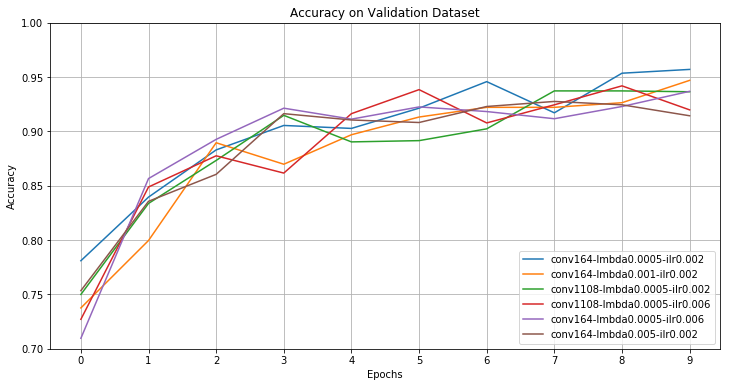

In [76]:
#Take the top k configurations out of the 36 above,
#ranked by their average accuracy over the last 4 epochs.

val_accs_avg = np.array([np.mean(entry[6:10]) for entry in val_accs_array])

k = 6
top_indices = np.argsort(val_accs_avg)[-k:][::-1]
top_configs = np.take(val_accs_array, top_indices, axis=0)
top_config_titles = np.take(val_accs_titles, top_indices, axis=0)

fig4, ax4 = plt.subplots(figsize=(12,6))

for val, title in zip(top_configs, top_config_titles):
    ax4.plot(range(0,len(val)), val, label=title)
    ax4.set_xlabel('Epochs')
    ax4.set_xticks(range(0,len(val),1))
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim([0.7,1])
    ax4.set_title('Accuracy on Validation Dataset')
    ax4.legend(loc=4)
    ax4.grid(True)

plt.show()

---
## 10. Final Model Training

I'll pick a winner from the above experiments and see how much more I can get out of it by training on the expanded training dataset (note that the experiments above were conducted with the original training dataset), by training longer, playing with dropout and initialization methods, and by tweaking the learning and L2 regularization rates yet a bit more.

I'll use the following configuration from the first testing phase above as the candidate for the final model:
- 1 input channel, i.e. grayscale input
- 2 convolutional layers, 108-200
- Convolutional filter size of 5x5 with a stride of 1 in each direction for both convolutional layers
- Max-pooling layers after each of the convolutional layers with a ksize and stride of 2 in each direction
- 2 fully connected layer with 100-43, the second going into a softmax classifier
- Batch normalization before the non-linearities of each layer (not before softmax)
- ReLU non-linearities for the first three layers
- Initial learning rate of 0.002, decaying stepwise exponentially with a decay rate of 0.9
- L2 regularization rate of 0.0005
- Weights initialization according to He et al.

The weights are being initialized randomly according to [He et al.](https://arxiv.org/abs/1502.01852), i.e. using a normal distribution with mean zero and a standard deviation of 1/sqrt(n_inputs/2). This is identical to Xavier initialization except for the factor 1/2 in the square root that He et al. compute as needed to adjust for the use of ReLUs as non-linearities.


In [51]:
def build_graph_p2():
    
    #Set up a decaying learning rate.
    #It will decay exponentially at a rate of 'decay_rate', but only every 'decay_steps' steps.
    ilr_BN = 0.002 #The initial learning rate
    global_step_BN = tf.Variable(0, trainable=False) #This will be incremented by the 'minimize' function below.
    learning_rate_BN = tf.train.exponential_decay(ilr_BN, global_step_BN, decay_steps=800, decay_rate=0.9, staircase=True)
    
    #L2 regularization factor
    lmbda_BN = 0.0005
    
    n_input_channels = 1 #The number of color channels of the input data
    
    #The depth (i.e. number of conv feature maps / number of fully connected hidden neurons) of each layer.
    layer_depth = {'conv1': 108,
                   'conv2': 200,
                   'fc1': 100,
                   'fc2': 43}
    
    #The convolutional filter size. Only one number is needed per layer since we're
    #using square filters (i.e. height = width) of identical size for all feature maps within a given layer.
    fsize = {
        '1': 5,
        '2': 5
    }
    
    #The convolutional stride and max pooling ksize are the same for all layers
    #and the pooling stride is always identical to the ksize.
    conv_stride = 1
    pool_k = 2
    
    #Placeholders for the dropout keep probability and the is_training flag.
    is_training = tf.placeholder(tf.bool)
    keep_prob = tf.placeholder(tf.float32)
    
    #Placeholders for the inputs.
    X = tf.placeholder(tf.float32, (None, 32, 32, n_input_channels))
    y = tf.placeholder(tf.int32, (None))
    y_one_hot = tf.one_hot(y, 43)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x108.
    conv1_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['1'], fsize['1'], n_input_channels, layer_depth['conv1']), stddev = 1/(fsize['1']*np.sqrt(n_input_channels/2))))
    conv1_beta = tf.Variable(tf.zeros(layer_depth['conv1'])) #Scale for batch normalization. Learnable parameter.
    conv1_gamma = tf.Variable(tf.ones(layer_depth['conv1'])) #Offset for batch normalization. Learnable parameter.
    conv1_pop_mean = tf.Variable(tf.zeros(layer_depth['conv1']), trainable=False) #An estimator of the population mean, estimated over the course of training. Not learnable.
    conv1_pop_var = tf.Variable(tf.ones(layer_depth['conv1']), trainable=False) #An estimator of the population variance, estimated over the course of training. Not learnable.
    conv1_BN = tf.nn.conv2d(X, conv1_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    conv1_BN = batch_normalization(conv1_BN, is_training, conv1_beta, conv1_gamma, conv1_pop_mean, conv1_pop_var, layer_type='conv')
    conv1_BN = tf.nn.relu(conv1_BN)
    #conv1_BN = tf.nn.dropout(conv1_BN, keep_prob)

    # Pooling. Input = 28x28x108. Output = 14x14x108.
    conv1_BN = tf.nn.max_pool(conv1_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x108. Output = 10x10x200.
    conv2_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['2'], fsize['2'], layer_depth['conv1'], layer_depth['conv2']), stddev = 1/(fsize['2']*np.sqrt(layer_depth['conv1']/2))))
    conv2_beta = tf.Variable(tf.zeros(layer_depth['conv2']))
    conv2_gamma = tf.Variable(tf.ones(layer_depth['conv2']))
    conv2_pop_mean = tf.Variable(tf.zeros(layer_depth['conv2']), trainable=False)
    conv2_pop_var = tf.Variable(tf.ones(layer_depth['conv2']), trainable=False)
    conv2_BN = tf.nn.conv2d(conv1_BN, conv2_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    batch_m, batch_v = tf.nn.moments(conv2_BN, axes=[0, 1, 2])
    conv2_BN = batch_normalization(conv2_BN, is_training, conv2_beta, conv2_gamma, conv2_pop_mean, conv2_pop_var, layer_type='conv')
    conv2_BN = tf.nn.relu(conv2_BN)
    #conv2_BN = tf.nn.dropout(conv2_BN, keep_prob)
    
    # Pooling. Input = 10x10x200. Output = 5x5x200.
    conv2_BN = tf.nn.max_pool(conv2_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Flatten. Input = 5x5x200. Output = 5,000.
    fc0_BN = flatten(conv2_BN)
    
    # Layer 3: Fully Connected. Input = 5,000. Output = 100.
    fc1_W_BN = tf.Variable(tf.truncated_normal(shape=(5*5*layer_depth['conv2'],layer_depth['fc1']), stddev = 1/np.sqrt(5*5*layer_depth['conv2']/2)))
    fc1_beta = tf.Variable(tf.zeros(layer_depth['fc1']))
    fc1_gamma = tf.Variable(tf.ones(layer_depth['fc1']))
    fc1_pop_mean = tf.Variable(tf.zeros(layer_depth['fc1']), trainable=False)
    fc1_pop_var = tf.Variable(tf.ones(layer_depth['fc1']), trainable=False)
    fc1_BN = tf.matmul(fc0_BN, fc1_W_BN)
    fc1_BN = batch_normalization(fc1_BN, is_training, fc1_beta, fc1_gamma, fc1_pop_mean, fc1_pop_var, layer_type='fc')
    fc1_BN = tf.nn.relu(fc1_BN)
    #fc1_BN = tf.nn.dropout(fc1_BN, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc2_W_BN = tf.Variable(tf.truncated_normal(shape=(layer_depth['fc1'],layer_depth['fc2']), stddev = 1/np.sqrt(layer_depth['fc1']/2)))
    fc2_b_BN = tf.Variable(tf.zeros(layer_depth['fc2']))
    logits_BN = tf.matmul(fc1_BN, fc2_W_BN) + fc2_b_BN
    softmax_BN = tf.nn.softmax(logits_BN) #This is not the input to the loss op, but we need it for other reasons.
    
    #Softmax with cross entropy loss
    loss_BN = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits_BN, labels=y_one_hot)) + lmbda_BN*(tf.nn.l2_loss(conv1_W_BN) + tf.nn.l2_loss(conv2_W_BN) + tf.nn.l2_loss(fc1_W_BN) + tf.nn.l2_loss(fc2_W_BN))
    
    #Adam minimizer
    training_step_BN = tf.train.AdamOptimizer(learning_rate=learning_rate_BN).minimize(loss_BN, global_step=global_step_BN)
    
    #Prediction accuracy op
    correct_prediction_BN = tf.equal(tf.argmax(logits_BN, 1), tf.argmax(y_one_hot, 1))
    accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))
    
    return (X,
            y,
            is_training,
            keep_prob,
            softmax_BN,
            training_step_BN,
            accuracy_BN,
            correct_prediction_BN,
            tf.train.Saver()
           )


In [ ]:
#Perform the training

epochs = 20
batch_size = 128

start_time = time.time()
tf.reset_default_graph()

p2_model_acc = []
p2_model_acc_steps = []

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

#Run the training session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    k = 0 #Counter for the number of training steps (i.e. number of minit batches processed)

    print("Training...")
    print()
    for i in range(epochs):
        print("EPOCH {} ...".format(i+1))
        print()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            #Create a mini batch
            end = offset + batch_size
            batch_X, batch_y = X_train[offset:end], y_train[offset:end]
            #Run a training step
            sess.run(training_step, feed_dict={
                X: batch_X,
                y: batch_y,
                keep_prob: 0.5,
                is_training: True})
            k += 1
            
        #Evaluate accuracy
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        p2_model_acc.append(validation_accuracy)
        p2_model_acc_steps.append(k)
        print("Number of training steps: {}".format(k))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time elapsed: %s seconds" % round(time.time() - start_time, 0))
        print()
    
    model_name = solution_dir +'p2_model_02_nodropout_augdata'
    saved_model = saver.save(sess, model_name)
    print("Model saved as {}".format(model_name))
    print()

p2_model_acc = np.array(p2_model_acc)
p2_model_acc_steps = np.array(p2_model_acc_steps)
np.save('{}_accs'.format(model_name), p2_model_acc)
np.save('{}_steps'.format(model_name), p2_model_acc_steps)

Training...

EPOCH 1 ...

Number of training steps: 859
Training Accuracy = 0.950
Validation Accuracy = 0.927
Time elapsed: 31.0 seconds

EPOCH 2 ...

Number of training steps: 1718
Training Accuracy = 0.987
Validation Accuracy = 0.937
Time elapsed: 59.0 seconds

EPOCH 3 ...

Number of training steps: 2577
Training Accuracy = 0.987
Validation Accuracy = 0.943
Time elapsed: 88.0 seconds

EPOCH 4 ...

Number of training steps: 3436
Training Accuracy = 0.991
Validation Accuracy = 0.946
Time elapsed: 117.0 seconds

EPOCH 5 ...

Number of training steps: 4295
Training Accuracy = 0.996
Validation Accuracy = 0.952
Time elapsed: 145.0 seconds

EPOCH 6 ...

Number of training steps: 5154
Training Accuracy = 0.997
Validation Accuracy = 0.953
Time elapsed: 174.0 seconds

EPOCH 7 ...

Number of training steps: 6013
Training Accuracy = 0.994
Validation Accuracy = 0.957
Time elapsed: 203.0 seconds

EPOCH 8 ...

Number of training steps: 6872
Training Accuracy = 0.996
Validation Accuracy = 0.957
Time

The winner of my final tests is the model_02 that you can see above. It does not use dropout and was trained on the expanded training dataset. Using dropout probably wouldn't have harmed, but it didn't seem necessary either.

Final small adjustments of the learning and L2 regularization rates yielded inconclusive results, indicating that an initial learning rate of 0.002 and an L2 regularization rate of 0.0005 are good values for this particular model.

Training for longer than 20 epochs - I tried 30 and 40 - didn't yield clear improvements.

Whether the weights were initialized with a constant global standard deviation of 0.01 or with the method proposed by He et al. didn't appear to make a structural difference - this model is probably too shallow for it to make much of a difference.

Below you can see how the accuracy on the validation dataset evolves, and the accuracy on the test dataset.


Final accuracy on the validation dataset = 0.978



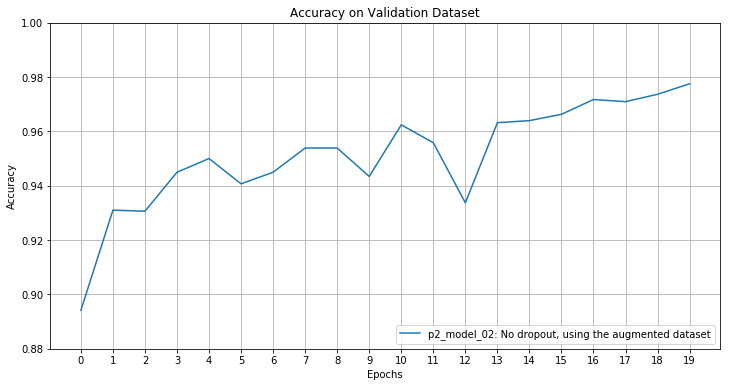

In [77]:
#Plot the accuracies on the validation dataset

p2_model_02_nodropout_augdata = np.load(solution_dir +'p2_model_02_nodropout_augdata_accs.npy')

print()
print("Final accuracy on the validation dataset = {:.3f}".format(p2_model_02_nodropout_augdata[-1]))
print()

fig5, ax5 = plt.subplots(figsize=(12,6))

ax5.plot(range(0,len(p2_model_02_nodropout_augdata)), p2_model_02_nodropout_augdata, label='p2_model_02: No dropout, using the augmented dataset')
ax5.set_xlabel('Epochs')
ax5.set_xticks(range(0,len(p2_model_02_nodropout_augdata),1))
ax5.set_ylabel('Accuracy')
ax5.set_ylim([0.88,1])
ax5.set_title('Accuracy on Validation Dataset')
ax5.legend(loc=4)
ax5.grid(True)

plt.show()

Now let's look at what really matters, performance on the test dataset:

In [81]:
# Evaluate the model on the test dataset

tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

with tf.Session() as sess:
    saver.restore(sess, solution_dir +'p2_model_02_nodropout_augdata')
    test_accuracy = evaluate(X_test, y_test)
    print()
    print("Accuracy on the test dataset = {:.3f}".format(test_accuracy))
    print()


Accuracy on the test dataset = 0.979



---

## 11. Testing the Model on New Images

Just for fun I'll test this model on a bunch of pictures of German traffic signs that I took myself (I happen to be German). I'll also test it on just a few images I found on the internet of what I believe to be very hard cases.

The 20 images shown below are pictures I took in my hometown in Germany.

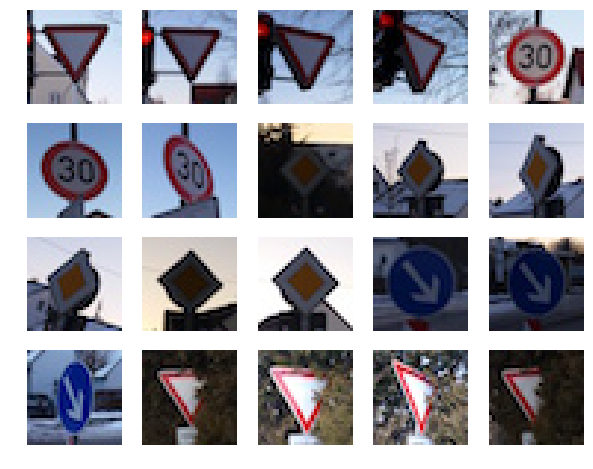

In [78]:
#Load, display and preprocess my own test images.

from PIL import Image
import glob

testimgs = []
filelist = glob.glob(solution_dir +'testimgs/test/*.jpg')
filelist = sorted(filelist)

for filename in filelist:
    with Image.open(filename) as img:
        arr = np.array(img)
        testimgs.append(arr)

f4, cell4 = plt.subplots(4, 5, figsize=(10,8))
for i in range(4):
    for j in range(5):
        cell4[i, j].imshow(testimgs[5*i+j])
        cell4[i, j].axis('off')
        #cell4[i, j].set_title('image {}'.format(5*i+j))

#Convert to grayscale and zero-mean normalize.
X_home = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testimgs]), 3) - channel_mean
y_home = np.array([13, 13, 13, 13, 1, 1, 1, 12, 12, 12, 12, 12, 12, 38, 38, 38, 13, 13, 13, 13])


All pictures were taken just before sunset. There is at least one perspectively distorted image for each of the five physical traffic signs shown. The GTSRB dataset contains perspective distortions, too, but only very few that are as strongly distorted. Hence the model might have difficulties to correctly classify the distorted images, numbers 3, 6, 9, 15, and 18 (counting from 0). The lighting on some signs is very dark, but this circumstance is abundantly covered in the training dataset, so no difficulties are to be expected here. The series of images of the second physical yield sign is special because that particular yield sign is partially concealed by the tree surrounding it. The occlusion is most severe in the last image, where only about half of the yield sign is visible. This, too, might lead to difficulties for the model.

Let's run the model on these images to see what we get.

Accuracy on my own images = 0.900

The following images were classified incorrectly:

Image 6 was incorrectly classified as 'Right-of-way at the next intersection', while it actually is 'Speed limit (30km/h)'.
Image 9 was incorrectly classified as 'No vehicles', while it actually is 'Priority road'.


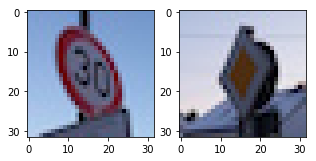

In [95]:
#Run the model on the above 20 images.

tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

with tf.Session() as sess:
    saver.restore(sess, solution_dir +'p2_model_02_nodropout_augdata')
    #home_accuracy = evaluate(X_home, y_home)
    res2 = sess.run([softmax,
                     correct_prediction,
                     tf.nn.top_k(softmax, k=3)],
                    feed_dict={X: X_home,
                               y: y_home,
                               is_training: False,
                               keep_prob: 1})
    home_accuracy = np.mean(res2[1].astype(np.int32))
    print("Accuracy on my own images = {:.3f}".format(home_accuracy))
    print()

print("The following images were classified incorrectly:")
print()

#Find the indices of the images that were classified incorrectly.
incorrect_inds = np.squeeze(np.argwhere(res2[1]==False))
incorrect_imgs = np.take(testimgs, incorrect_inds, axis=0)
incorrect_labels = np.argmax(np.take(res2[0], incorrect_inds, axis=0), axis=1)

for k in range(len(incorrect_inds)):
    print("Image {} was incorrectly classified as '{}', while it actually is '{}'.".format(incorrect_inds[k], signnames[incorrect_labels[k]], signnames[y_home[incorrect_inds[k]]]))

f5, cell5 = plt.subplots(1, len(incorrect_inds), figsize=(5,4))
for i in range(len(incorrect_inds)):
    cell5[i].imshow(incorrect_imgs[i])


As you can see, the model performs slightly worse on my own test images than it does on the GTSRB test dataset, reaching 90% accuracy on my own test images. The significance of this number is limited, of course, since we are looking at only 20 images here, with a disproportionately high ratio of strongly perspectively distorted images (60% of which are still being classified correctly). As was expected, the model performs less well on perspectively distorted images: Both of the two images that it got wrong are perspectively distorted. I can't really explain the two incorrect classifications - god knows how the model ended up classifying the 'Priority road' sign as a 'No vehicles' sign. Surprisingly, the partially concealed yield sign was not a problem for the classifier.

Below I ran the model on four hard images that I found on the internet, two yield signs and two general caution signs. The first three signs are partially covered by snow, the second sign even completely. More than two thirds of the last sign are concealed by a plant. Surprisingly, the model still got an accuracy of 50% on these hard images, correctly classifying the two yield signs, but not the two caution signs. It is remarkable that the small patch of red and white in the last image was sufficient for the model to classify the sign correctly.

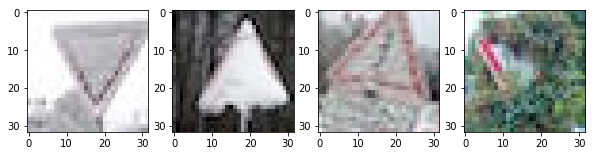

In [96]:
hardimgs = []
filelist2 = glob.glob(solution_dir +'testimgs/hard/*.jpg')
filelist2 = sorted(filelist2)

for filename in filelist2:
    with Image.open(filename) as img:
        arr2 = np.array(img)
        hardimgs.append(arr2)

f6, cell6 = plt.subplots(1, 4, figsize=(10, 8))
for i in range(4):
    cell6[i].imshow(hardimgs[i])
    #cell6[i, j].set_title('image {}'.format(5*i+j))

#Convert to grayscale and zero-mean normalize.
X_hard = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in hardimgs]), 3) - channel_mean
y_hard = np.array([13, 18, 18, 13])

Accuracy on my own images = 0.500

Image 1 was incorrectly classified as 'Priority road', while it actually is 'General caution'.
Image 2 was incorrectly classified as 'Roundabout mandatory', while it actually is 'General caution'.


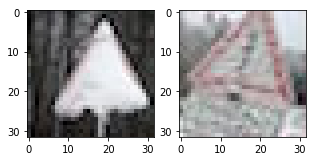

In [98]:
#Run the model on 4 hard images I found on the internet.

tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

with tf.Session() as sess:
    saver.restore(sess, solution_dir +'p2_model_02_nodropout_augdata')
    #hard_accuracy = evaluate(X_hard, y_hard)
    res3 = sess.run([softmax,
                     correct_prediction,
                     tf.nn.top_k(softmax, k=3)],
                    feed_dict={X: X_hard,
                               y: y_hard,
                               is_training: False,
                               keep_prob: 1})
    hard_accuracy = np.mean(res3[1].astype(np.int32))
    print("Accuracy on my own images = {:.3f}".format(hard_accuracy))
    print()

#Find the indices of the images that were classified incorrectly.
incorrhard_inds = np.squeeze(np.argwhere(res3[1]==False))
incorrhard_imgs = np.take(hardimgs, incorrhard_inds, axis=0)
incorrhard_labels = np.argmax(np.take(res3[0], incorrhard_inds, axis=0), axis=1)

for k in range(len(incorrhard_inds)):
    print("Image {} was incorrectly classified as '{}', while it actually is '{}'.".format(incorrhard_inds[k], signnames[incorrhard_labels[k]], signnames[y_hard[incorrhard_inds[k]]]))

f7, cell7 = plt.subplots(1, len(incorrhard_inds), figsize=(5,4))
for i in range(len(incorrhard_inds)):
    cell7[i].imshow(incorrhard_imgs[i])


I'll do one last thing: I'll visualize the softmax probabilities of the final model on my 20 test images from above to see how certain the model is of its predictions. I'll also list the top-3 classes for those images that the model classified incorrectly to see if the correct classes are at least among the top 3. for Let's take a look:

Here are the softmax probabilities for the incorrectly classified images:

Top-3 classes: [11 36 19] (correct would have been 1)
Top-3 probabilities: [ 0.4091  0.1342  0.102 ]
Top-3 classes: [15 13 22] (correct would have been 12)
Top-3 probabilities: [ 0.9793  0.0072  0.0051]

Here are the softmax histograms for all 20 images:


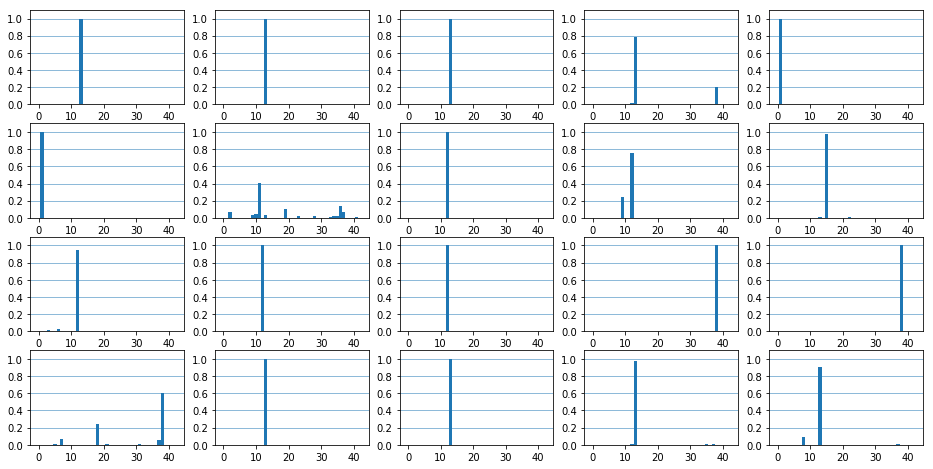

In [99]:
# Visualize the softmax probabilities for the 20 test images.

print("Here are the softmax probabilities for the incorrectly classified images:")
print()

np.set_printoptions(suppress=True, precision=4)
for index in incorrect_inds:
    print("Top-3 classes:", res2[2][1][index], "(correct would have been {})".format(y_home[index]))
    print("Top-3 probabilities:", res2[2][0][index])

print()
print("Here are the softmax histograms for all 20 images:")

f8, cell8 = plt.subplots(4, 5, figsize=(16,8))

for i in range(4):
    for j in range(5):
        cell8[i, j].bar(range(len(res2[0][5*i+j])), height=res2[0][5*i+j], width=1)
        cell8[i, j].set_ylim([0,1.1])
        cell8[i, j].set_yticks(np.arange(0,1.1,0.2))
        for ymaj in cell8[i, j].yaxis.get_majorticklocs():
            cell8[i, j].axhline(y=ymaj, linewidth=0.5)
        #cell8[i, j].set_title('image {}'.format(5*i+j))

As you can see above, the model is for the most part extremely certain of its predictions - almost to a worrisome extent: It attributes a probability of around 97% to one of its incorrect classifications. Fortunately it only attributes a probability of around 41% to its other incorrect classification, making it the lowest certainty for any of the 20 classifications, which is a good thing. Exaggerated certainty is a problem that can be partly attributed to the softmax function itself I guess: Since the exponential function grows so fast, the activation for the model's predicted class needs to be only slightly larger than the other activations in the last layer to already cause a huge difference in the softmax probability. Sadly, the correct class isn't even in the top-3 for either of the two inccorect ones.